# LIS DQN

In [1]:
import sys
tmp_path = []
for it in sys.path:
    if not 'gym' in it:
        # print(it)
        tmp_path.append(it)
sys.path = tmp_path
sys.path.append('../..')

In [2]:
from __future__ import print_function
import copy
import os
import random
import collections
import numpy as np
import six.moves.cPickle as pickle

import gym
from PIL import Image

import chainer
from chainer import cuda, FunctionSet, Variable, optimizers
from chainer import links as L
import chainer.functions as F
from chainer.links import caffe

%matplotlib notebook
import matplotlib.pyplot as plt

# CnnFeatureExtractor

In [3]:
class CnnFeatureExtractor:
    def __init__(self, gpu, model_file, in_size, mean_file, feature_name):
        self.gpu = gpu
        self.model_file = model_file
        self.mean_file = mean_file
        self.feature_name = feature_name
        self.in_size = in_size
        self.batchsize = 1

        if self.gpu >= 0:
            cuda.check_cuda_available()

        print('Loading Caffe model file %s...' % self.model_file, file = sys.stderr)
        self.func = caffe.CaffeFunction(self.model_file)
        print('Loaded', file=sys.stderr)
        if self.gpu >= 0:
            cuda.get_device(self.gpu).use()
            self.func.to_gpu()

        mean_image = np.load(self.mean_file)
        self.mean_image = self.crop(mean_image)

    def forward(self, x, t):
        y, = self.func(inputs={'data': x}, outputs=[self.feature_name], train=False)
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

    def predict(self, x):
        y, = self.func(inputs={'data': x}, outputs=[self.feature_name], train=False)
        return F.softmax(y)

    def feature(self, camera_image):
        x_batch = np.ndarray((self.batchsize, 3, self.in_size, self.in_size), dtype=np.float32)
        image = np.asarray(camera_image).transpose(2, 0, 1)[::-1].astype(np.float32)
        image = self.crop(image)
        image -= self.mean_image

        x_batch[0] = image
        xp = cuda.cupy if self.gpu >= 0 else np
        x_data = xp.asarray(x_batch)

        if self.gpu >= 0:
            x_data=cuda.to_gpu(x_data)

        x = chainer.Variable(x_data, volatile=True)
        feature = self.predict(x)
        feature = feature.data

        if self.gpu >= 0:
            feature = cuda.to_cpu(feature)
        feature = self.vec(feature)

        return feature * 255.0

    def crop(self, image):
        #assume image is square
        cropwidth = image.shape[1] - self.in_size
        start = cropwidth // 2
        stop = start + self.in_size
        return image[:, start:stop, start:stop].copy()

    #vectrization, or mat[:] in MATLAB
    def vec(self, mat):
        return mat.reshape(mat.size)

# QNet

In [4]:
class QFunction(chainer.Chain):

    def __init__(self, input_dim, n_actions):
        initializer = chainer.initializers.HeNormal()

        fc_unit = 256
        super(QFunction, self).__init__(
            fc1=L.Linear(input_dim, fc_unit),
            fc2=L.Linear(fc_unit, n_actions),
        )

    def __call__(self, x):
        h = x/255.
        h = F.relu(self.fc1(h))
        y = self.fc2(h)        
        return y

In [5]:
def get_greedy_action(Q, obs):
    xp = Q.xp
    obs = xp.expand_dims(xp.asarray(obs, dtype=np.float32), 0)
    with chainer.no_backprop_mode():
        q = Q(obs).data[0]
    return int(xp.argmax(q))

In [6]:
def mean_clipped_loss(y, t):
    # Add an axis because F.huber_loss only accepts arrays with ndim >= 2
    y = F.expand_dims(y, axis=-1)
    t = F.expand_dims(t, axis=-1)
    return F.sum(F.huber_loss(y, t, 1.0)) / y.shape[0]

In [7]:
def update(Q, target_Q, opt, samples, gamma=0.99, target_type='dqn'): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, q_net_input_dim), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
    r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
    done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
    s_next = np.ndarray(shape=(minibatch_size, q_net_input_dim), dtype=np.float32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0].flatten()
        s_next[i] = samples[i][4].flatten()

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)
    r = xp.asarray(r)
    done = xp.asarray(done)
    s_next = xp.asarray(s_next)
    
    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    # Target: r + gamma * max Q_b (s',b)
    with chainer.no_backprop_mode():
        if target_type == 'dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.max(target_Q(s_next), axis=1)
        elif target_type == 'double_dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.select_item(
                target_Q(s_next), F.argmax(Q(s_next), axis=1))
        else:
            raise ValueError('Unsupported target_type: {}'.format(target_type))
    loss = mean_clipped_loss(y, t)
    Q.cleargrads()
    loss.backward()
    opt.update()

In [8]:
def meanQvalue(Q, samples): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, q_net_input_dim), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0].flatten()

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)

    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    mean_Q = (F.sum(y)/minibatch_size).data
    return mean_Q
  

# 入力画像をStateへ変換

In [9]:
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network

class ObsProcesser:
    mean_file = 'ilsvrc_2012_mean.npy'
    mean_name, ext = os.path.splitext(mean_file)

    def __init__(self, networkname='googlenet'):
        self.state = None

        if networkname is 'googlenet':
            #GoogLeNet
            self.in_size = 224
            self.model_file = 'bvlc_googlenet.caffemodel'
            self.feature_name = 'pool5/7x7_s1' #aka loss3/fc
            
        elif networkname is 'alexnet':
            #AlexNet
            self.in_size = 227
            self.model_file = 'bvlc_alexnet.caffemodel'
            self.feature_name = 'pool5'
        else:
            print('unknown networkn name')

        model_name, ext = os.path.splitext(self.model_file)
        self.cnn_feature_extractor = model_name + '.' + self.mean_name + '.' + self.feature_name + '.extractor.pickle'
        self.cnn_feature_extractor = self.cnn_feature_extractor.replace('/', '_')
        
        if os.path.exists(self.cnn_feature_extractor):
            print("loading... " + self.cnn_feature_extractor),
            self.feature_extractor = pickle.load(open(self.cnn_feature_extractor))
            print("done")
        else:
            self.feature_extractor = CnnFeatureExtractor(self.use_gpu,
                self.model_file, self.in_size, self.mean_file, self.feature_name)
            pickle.dump(self.feature_extractor, open(self.cnn_feature_extractor, 'wb'),-1)
            print("pickle.dump finished")
            
    def init_state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        state = [processed_obs for _ in xrange(STATE_LENGTH)]
        self.state = np.stack(state, axis=0)
        
    def obs2state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        self.state = np.concatenate((self.state[1:, :], processed_obs[np.newaxis]), axis=0)
        return self.state
    
    def _preprocess_observation(self, obs):
        preprossed = np.r_[self.feature_extractor.feature(obs["image"][0]),
                           obs["depth"][0]/255.]
        return preprossed

# Lis_DQN

In [10]:
# Initialize variables
depth_image_dim = 32 * 32
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network
M = 10000  # number of episodes
replay_start_size = 1000  # steps after which we start to update
steps_to_decay_epsilon = 100000  # steps to take to decay epsilon
min_epsilon = 0.1  # minimum value of epsilon
sync_interval = 5000  # interval of target sync
evaluation_interval = 50 # 何エピソードごとに評価するか
update_inverval = 1
minibatch_size = 32  # size of minibatch
update_inverval = 1
reward_scale = 1  # scale factor for rewards
gpu = 0  # gpu id (-1 to use cpu)
target_type = 'dqn'  # 'dqn' or 'double_dqn'
NO_OP_MAX = 20 # maximum number of "do anything" actions at the start of an episode
save_model_inverval = 25000 # interval of save weights
D = collections.deque(maxlen=10 ** 5)  # replay memory: original 10 ** 6

Rs = []  # past returns
average_Rs = []
eval_Rs = [] # evaluation Max reward
eval_steps = [] # evaluation Max
step = 0  # total steps taken
episode = 0

networkname = 'googlenet'
obs_processer = ObsProcesser(networkname)
log_file = 'reward_'+networkname+'.log'

loading... bvlc_googlenet.ilsvrc_2012_mean.pool5_7x7_s1.extractor.pickle
done


In [11]:
#One-time FF to get the feature length
image = Image.new("RGB", (256, 256)) # dummy image
image_feature_dim = obs_processer.feature_extractor.feature(image).size
q_net_input_dim = (image_feature_dim + depth_image_dim)*STATE_LENGTH
enable_controller = [0,1,2]
n_actions = len(enable_controller)

In [12]:
# Initialize chainer models
Q = QFunction(q_net_input_dim, n_actions)
if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    Q.to_gpu(gpu)
target_Q = copy.deepcopy(Q)
opt = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.95, eps=0.0001)
opt.setup(Q)

# Initialize

In [13]:
# disable stderre
import os
import sys
f = open(os.devnull, 'w')
sys.stderr = f

In [14]:
with open(log_file, 'w') as the_file:
    the_file.write('cycle, episode_reward_sum \n')

In [15]:
env = gym.make('Lis-v2')
obs = env.reset()
obs_processer.init_state(obs)
state = obs_processer.state

# Show observation image

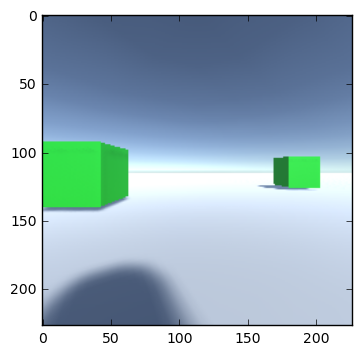

In [16]:
%matplotlib inline
plt.imshow(np.array(obs['image'][0]))

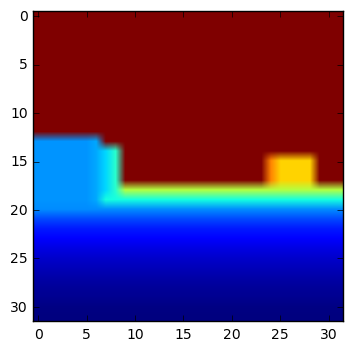

In [17]:
plt.imshow(obs['depth'][0].reshape(32,32))

# Evaluation

In [18]:
def Evaluation(epsilon = 0.05):
    Rs_eval = []  # past returns
    for episode in range(3):

        obs = env.reset()
        obs_processer.init_state(obs)

        for _ in range(random.randint(1, NO_OP_MAX)):
            a = env.action_space.sample()
            obs, _, _, _ = env.step(a)  # Do anything
            obs_processer.obs2state(obs)
            
        done = False
        R = 0.0
        state = obs_processer.state   

        while not done:
            # Select an action
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = get_greedy_action(Q, state)

            # Execute an action
            new_obs, r, done, _ = env.step(a)

            new_state = obs_processer.obs2state(new_obs)
            R += r
            state = new_state           

        print('Evaluation : episode: {} step: {} R:{}'.format(episode, step, R))
        Rs_eval.append(R)
    return Rs_eval

# Run

<IPython.core.display.Javascript object>


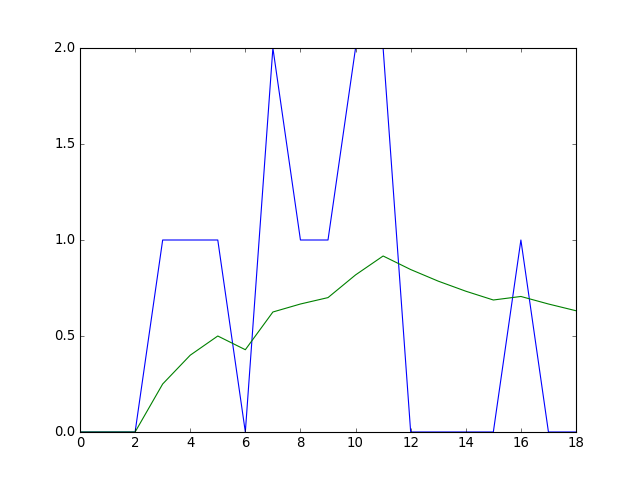

episode: 0 step: 81 R:0.0 average_R:0.0
episode: 1 step: 166 R:0.0 average_R:0.0
episode: 2 step: 244 R:0.0 average_R:0.0
episode: 3 step: 324 R:1.0 average_R:0.25
episode: 4 step: 410 R:1.0 average_R:0.4
episode: 5 step: 485 R:1.0 average_R:0.5
episode: 6 step: 571 R:0.0 average_R:0.428571428571
episode: 7 step: 663 R:2.0 average_R:0.625
episode: 8 step: 739 R:1.0 average_R:0.666666666667
episode: 9 step: 820 R:1.0 average_R:0.7
episode: 10 step: 903 R:2.0 average_R:0.818181818182
episode: 11 step: 984 R:2.0 average_R:0.916666666667
episode: 12 step: 1077 R:0.0 average_R:0.846153846154
episode: 13 step: 1154 R:0.0 average_R:0.785714285714
episode: 14 step: 1242 R:0.0 average_R:0.733333333333
episode: 15 step: 1317 R:0.0 average_R:0.6875
episode: 16 step: 1394 R:1.0 average_R:0.705882352941
episode: 17 step: 1470 R:0.0 average_R:0.666666666667
episode: 18 step: 1544 R:0.0 average_R:0.631578947368


In [ ]:
# Initialize a figure
%matplotlib notebook
fig, ax = plt.subplots(1,1)

while episode < M:
    obs = env.reset()
    obs_processer.init_state(obs)

    for _ in range(random.randint(1, NO_OP_MAX)):
        a = env.action_space.sample()
        obs, _, _, _ = env.step(a)  # Do anything
        obs_processer.obs2state(obs)
    done = False
    R = 0.0
    state = obs_processer.state   
    
    while not done:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [replay_start_size, replay_start_size+steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, _ = env.step(a)

        new_state = obs_processer.obs2state(new_obs)

        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            if step % update_inverval == 0:
                samples = random.sample(D, minibatch_size)
                update(Q, target_Q, opt, samples, target_type=target_type)

            if step % sync_interval == 0:
                mean_Q = meanQvalue(Q, samples)
                target_Q = copy.deepcopy(Q)
                print('target Q update! mean Q value : {}, epsilon:{}'.format(mean_Q, epsilon))

            if step % save_model_inverval == 0:
                save_model_filename = "lis_dqn_{}_{}.h5".format(env_name, step)
                print('save model : {}'.format(save_model_filename))
                chainer.serializers.save_hdf5(save_model_filename, Q)

        step += 1

    with open(log_file, 'a') as the_file:
        the_file.write(str(episode) + ',' + str(R) + '\n')

    Rs.append(R)
    average_R = np.mean(Rs[-50:])
    average_Rs.append(average_R)
    if episode % 1 is 0:
        print('episode: {} step: {} R:{} average_R:{}'.format(
              episode, step, R, average_R))

    # evaluation
    if (episode+1) % evaluation_interval == 0:
        R_eval = Evaluation()
        eval_Rs.append(max(R_eval))
        eval_steps.append(episode)

                
    ax.clear()
    ax.plot(Rs)
    ax.plot(average_Rs)
    ax.plot(eval_steps, eval_Rs, "o")
    fig.canvas.draw()
    episode += 1
    
env.close()